Data Loading & Cleaning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import random
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import Birch
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print("Libraries loaded successfully.")




Libraries loaded successfully.


In [3]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
np.random.seed(42)
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
987230,-0.751675,-0.405880,1.234974,-1.256401,-0.669618,-1.010457
79954,-0.604813,-0.129210,0.135406,-0.508040,-0.938868,-0.271504
567130,-0.497520,-0.214469,1.623337,-1.357419,0.340071,0.637976
500891,1.414472,1.539007,0.637057,-0.841294,0.878572,0.581134
55399,-0.829977,-1.025197,-0.699063,0.572155,-0.467680,-0.100977


Hopkins Statistic

In [3]:
# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

Hopkins Statistic: 0.99997884


K-Means

Elbow Method

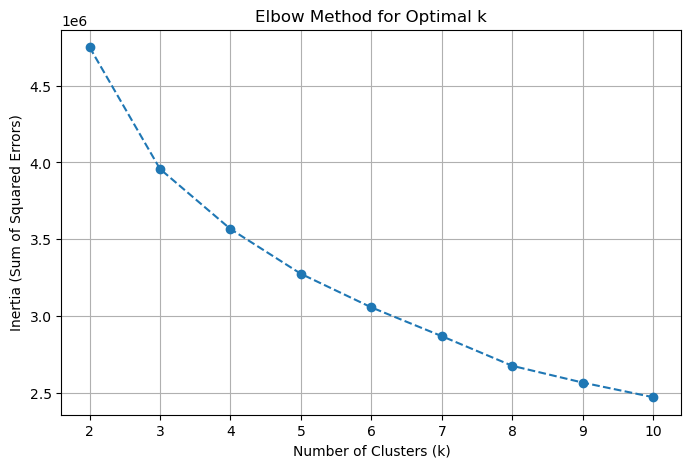

In [29]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [30]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


Application

In [31]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample_scaled.shape[0], k_optimal, replace=False)
centroids = X_sample_scaled[random_indices]

assignments = np.zeros(X_sample_scaled.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample_scaled, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample_scaled, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break


Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...


Visualization and analysis

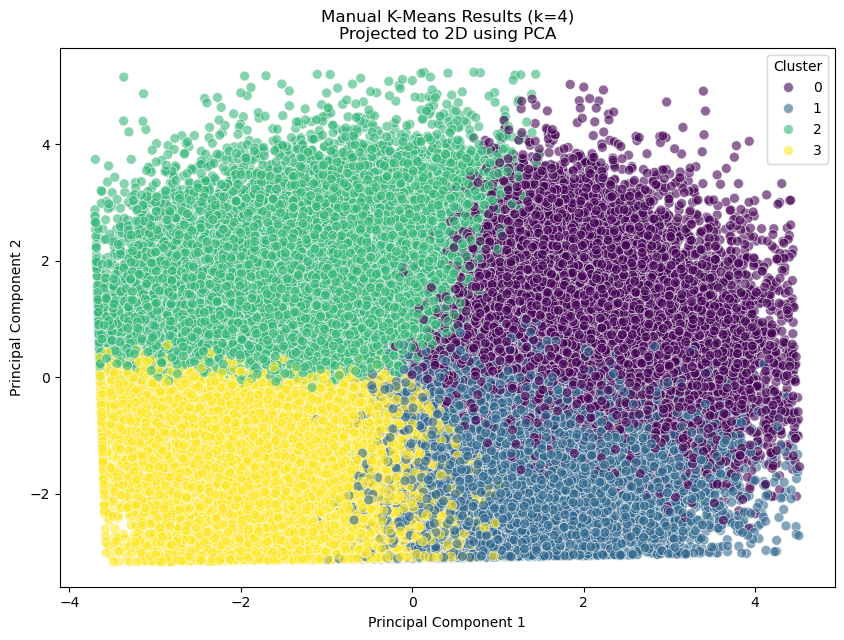


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  NumVotesIMDb  NumVotesRT  IMDbRating  RottenTomatoesScore
Cluster                                                                                              
0       25,070,607.11        71,742,333.41     14,500.50    2,042.36        5.81                56.60
1       12,926,233.72        35,473,511.05      2,495.09    2,085.13        7.55                77.35
2        2,003,353.87         4,890,242.64      6,917.49    2,094.05        5.16                48.84
3        1,499,237.79         3,600,665.86     12,788.58    1,929.20        7.58                77.73

Movies per Cluster:
 Cluster  NumMovies
       2      54886
       3      51245
       0      47373
       1      46495


In [32]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 
                'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))



Model Evaluation

In [33]:
# --- K-MEANS MODEL EVALUATION ---
# 2. ANOVA Validation Function 
def perform_anova_validation(df, cluster_col, features):
    """
    Realiza un test ANOVA de una vía para verificar diferencias significativas.
    """
    print(f"\nANOVA Validation for K-Means (Testing differences between {cluster_col} groups)")
    print("-" * 60)
    
    unique_clusters = sorted(df[cluster_col].unique())
    
    for feature in features:
        # Preparamos los grupos
        groups = [df[df[cluster_col] == c][feature] for c in unique_clusters]
        
        # Ejecutamos ANOVA
        f_stat, p_value = f_oneway(*groups)
        
        print(f"Feature: {feature}")
        print(f"  F-statistic: {f_stat:.2f} | P-value: {p_value:.4e}")
        
        if p_value < 0.05:
            print("  ✅ SIGNIFICANT: Distinct populations confirmed.")
        else:
            print("  ❌ NOT SIGNIFICANT: Clusters are indistinguishable.")

# --- EJECUCIÓN DEL ANÁLISIS ---

print("\n--- K-Means Evaluation Metrics ---")

# 2. Métricas Internas (Silhouette, DB, CH)
if X_sample_scaled.shape[0] > 100000:  
    print("Silhouette 100,000 points...")  
    np.random.seed(42)
    idx_eval = np.random.choice(X_sample_scaled.shape[0], 100000, replace=False) 
    X_eval = X_sample_scaled[idx_eval]
    labels_eval = assignments[idx_eval]
else:
    print(f"Calculando Silhouette con todos los {X_sample_scaled.shape[0]:,} puntos...")
    X_eval = X_sample_scaled
    labels_eval = assignments

sil = silhouette_score(X_eval, labels_eval)
print(f"Silhouette Score: {sil:.4f}")

db = davies_bouldin_score(X_sample_scaled, assignments)
print(f"Davies-Bouldin Index: {db:.4f}")

ch = calinski_harabasz_score(X_sample_scaled, assignments)
print(f"Calinski-Harabasz Index: {ch:.4f}")

# 3. ANOVA Validation (El paso crítico)
# Añadimos las etiquetas de K-Means al dataframe original
df_sample['Cluster_KMeans'] = assignments

features_to_validate = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'IMDbRating', 
    'RottenTomatoesScore',
    'NumVotesIMDb',
    'NumVotesRT'
]

perform_anova_validation(df_sample, 'Cluster_KMeans', features_to_validate)


--- K-Means Evaluation Metrics ---
Silhouette 100,000 points...
Silhouette Score: 0.1579
Davies-Bouldin Index: 1.6565
Calinski-Harabasz Index: 44472.6268

ANOVA Validation for K-Means (Testing differences between Cluster_KMeans groups)
------------------------------------------------------------
Feature: BudgetUSD
  F-statistic: 14255.50 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: Global_BoxOfficeUSD
  F-statistic: 12053.99 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: IMDbRating
  F-statistic: 74218.71 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: RottenTomatoesScore
  F-statistic: 76764.37 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: NumVotesIMDb
  F-statistic: 2316.59 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: NumVotesRT
  F-statistic: 4.16 | P-value: 5.9372e-03
  ✅ SIGNIFICANT: Distinct populations confirmed

BIRCH

BIRCH HYPERPARAMETER TUNING

Running BIRCH on sample data shape: (50000, 6)

--- Comparing Thresholds ---
Threshold T=0.5 -> Generated 9137 subclusters (4.4376s)
Threshold T=1.0 -> Generated 523 subclusters (0.7711s)
Threshold T=1.5 -> Generated 38 subclusters (0.3723s)
Threshold T=2.0 -> Generated 8 subclusters (0.3625s)
Threshold T=2.5 -> Generated 2 subclusters (0.3756s)


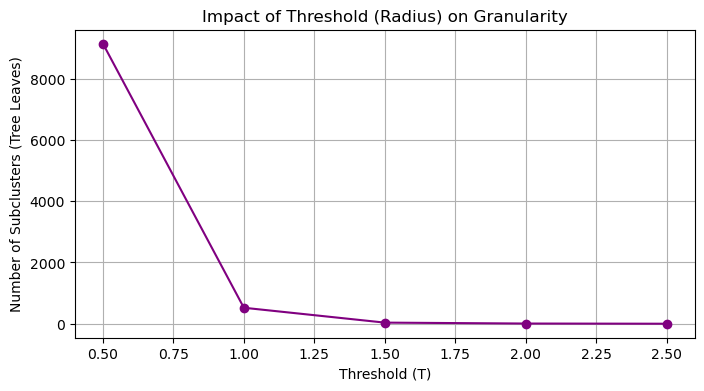

In [ ]:
#Im going to leave this as is because this was my first Birch test and 
#so i want to compare how it has changed 
#i have deleted the other cells that continued this pattern.
print(f"Running BIRCH on sample data shape: {X_sample_scaled.shape}")

#Threshold (T)
thresholds_to_test = [0.5, 1.0, 1.5, 2.0, 2.5] 
tuning_results = []

print("\n--- Comparing Thresholds ---")

for thresh in thresholds_to_test:
    start_time = time.time()
    
    #generate as many subclusters as the tree needs
    brc = Birch(threshold=thresh, n_clusters=None)
    brc.fit(X_sample_scaled)
    
    elapsed = time.time() - start_time
    num_subclusters = len(brc.subcluster_centers_)
    
    tuning_results.append({
        'Threshold': thresh,
        'Subclusters': num_subclusters,
        'Time_Sec': elapsed
    })
    print(f"Threshold T={thresh} -> Generated {num_subclusters} subclusters ({elapsed:.4f}s)")

results_df = pd.DataFrame(tuning_results)
plt.figure(figsize=(8, 4))
plt.plot(results_df['Threshold'], results_df['Subclusters'], marker='o', color='purple')
plt.title('Impact of Threshold (Radius) on Granularity')
plt.xlabel('Threshold (T)')
plt.ylabel('Number of Subclusters (Tree Leaves)')
plt.grid(True)
plt.show()

Shape of sample data used for BIRCH: (50000, 6)

--- Running BIRCH Threshold Tuning ---
T=0.5 -> Subclusters: 9137 | Sil: 0.1027 (9.48s)
T=1.0 -> Subclusters: 523 | Sil: 0.1053 (0.95s)
T=1.5 -> Subclusters: 38 | Sil: 0.1021 (0.36s)
T=2.0 -> Subclusters: 8 | Sil: 0.1262 (0.38s)


c:\Users\alvarodela.herran\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(


T=2.5 -> Subclusters: 2 | Sil: -1.0000 (0.40s)


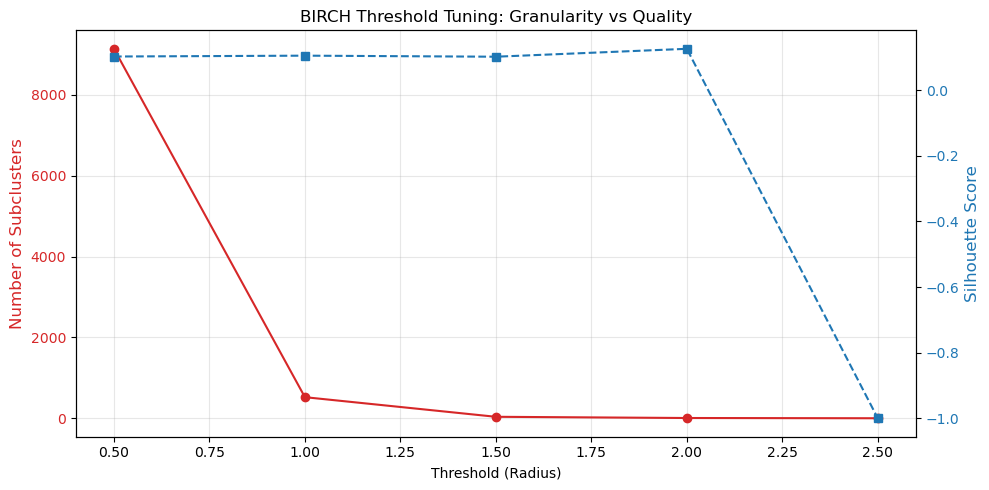

In [5]:
# 2. SAMPLING 

target_samples = 50000

if len(X_scaled_df) > target_samples:
    X_sample_scaled_df = X_scaled_df.sample(n=target_samples, random_state=42)
else:
    X_sample_scaled_df = X_scaled_df.copy()

sample_indices = X_sample_scaled_df.index
X_sample_scaled = X_sample_scaled_df.values
df_sample = df.loc[sample_indices]

print(f"Shape of sample data used for BIRCH: {X_sample_scaled.shape}")



# 3. TUNING THRESHOLD 

thresholds_to_test = [0.5, 1.0, 1.5, 2.0, 2.5] 
tuning_results = []

print("\n--- Running BIRCH Threshold Tuning ---")

for thresh in thresholds_to_test:
    start_time = time.time()
    
    brc = Birch(threshold=thresh, n_clusters=4)
    brc.fit(X_sample_scaled)
    labels = brc.predict(X_sample_scaled)
    
    elapsed = time.time() - start_time
    num_subclusters = len(brc.subcluster_centers_)
    
    
    if num_subclusters >= 4:  
        sil_score = silhouette_score(X_sample_scaled, labels)
    else:
        sil_score = -1 
    
    tuning_results.append({
        'Threshold': thresh,
        'Silhouette': sil_score,
        'Num_Subclusters': num_subclusters,
        'Time_Sec': elapsed
    })
    
    print(f"T={thresh} -> Subclusters: {num_subclusters} | Sil: {sil_score:.4f} ({elapsed:.2f}s)")



# 4. VISUALIZATION
results_df = pd.DataFrame(tuning_results)

fig, ax1 = plt.subplots(figsize=(10, 5))

#Subclusters
color = 'tab:red'
ax1.set_xlabel('Threshold (Radius)')
ax1.set_ylabel('Number of Subclusters', color=color, fontsize=12)
ax1.plot(results_df['Threshold'], results_df['Num_Subclusters'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Silhouette
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=12)  
ax2.plot(results_df['Threshold'], results_df['Silhouette'], marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('BIRCH Threshold Tuning: Granularity vs Quality')
plt.tight_layout()
plt.show()


#Note: The warning at 2.5 is normal. 
#It confirms the threshold is too high, 
#so we are intentionally letting the alert show so we dont miss that info


FINAL MODEL AND MODEL EVALUATION

In [6]:
final_threshold = 2.0  
final_k = 8

print(f"\nTraining Final BIRCH with (T={final_threshold}, k={final_k})")

# Train Model
brc_final = Birch(threshold=final_threshold, n_clusters=final_k)
labels = brc_final.fit_predict(X_sample_scaled)

df_sample['Cluster_BIRCH'] = labels

print(f"Model trained successfully!")
print(f"   Subclusters generated: {len(brc_final.subcluster_centers_)}")
print(f"   Final clusters: {len(np.unique(labels))}")

sil_final = silhouette_score(X_sample_scaled, labels)
dbi_final = davies_bouldin_score(X_sample_scaled, labels)
chi_final = calinski_harabasz_score(X_sample_scaled, labels)

print(f"Final Model Metrics:")
print(f"   Silhouette:        {sil_final:.4f}")
print(f"   Davies-Bouldin:    {dbi_final:.4f}")
print(f"   Calinski-Harabasz: {chi_final:.2f}")



Training Final BIRCH with (T=2.0, k=8)
Model trained successfully!
   Subclusters generated: 8
   Final clusters: 8
Final Model Metrics:
   Silhouette:        0.1481
   Davies-Bouldin:    1.4903
   Calinski-Harabasz: 8453.80


In [7]:
final_threshold = 2.0  
final_k = 4

print(f"\nTraining Final BIRCH with (T={final_threshold}, k={final_k})")

# Train Model
brc_final = Birch(threshold=final_threshold, n_clusters=final_k)
labels = brc_final.fit_predict(X_sample_scaled)

df_sample['Cluster_BIRCH'] = labels

print(f"Model trained successfully!")
print(f"   Subclusters generated: {len(brc_final.subcluster_centers_)}")
print(f"   Final clusters: {len(np.unique(labels))}")

sil_final = silhouette_score(X_sample_scaled, labels)
dbi_final = davies_bouldin_score(X_sample_scaled, labels)
chi_final = calinski_harabasz_score(X_sample_scaled, labels)

print(f"Final Model Metrics:")
print(f"   Silhouette:        {sil_final:.4f}")
print(f"   Davies-Bouldin:    {dbi_final:.4f}")
print(f"   Calinski-Harabasz: {chi_final:.2f}")



Training Final BIRCH with (T=2.0, k=4)
Model trained successfully!
   Subclusters generated: 8
   Final clusters: 4
Final Model Metrics:
   Silhouette:        0.1262
   Davies-Bouldin:    1.8732
   Calinski-Harabasz: 9168.20


Visualization + Profiling

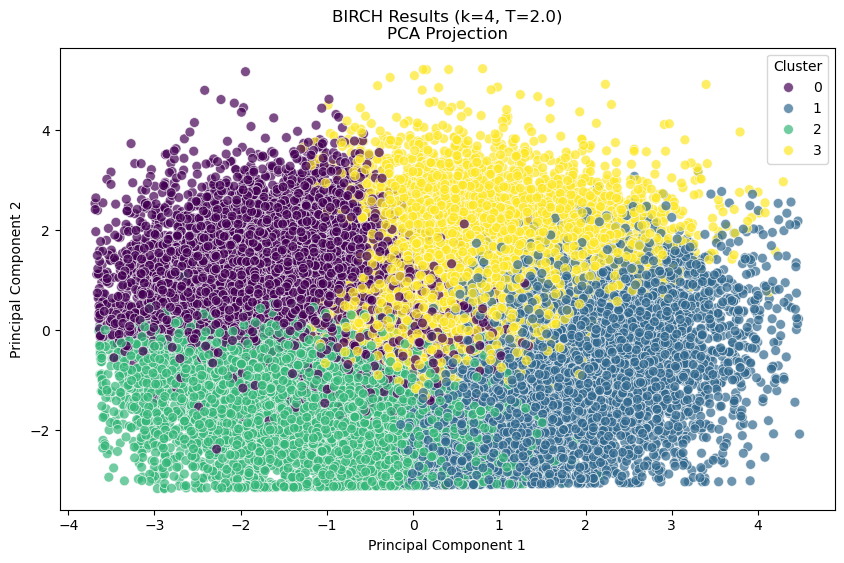


--- Cluster Profiles (Real Values) ---
                  BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore  NumVotesIMDb  NumVotesRT  Movie_Count
Cluster_BIRCH                                                                                                           
0              1,750,865.95         4,270,862.85        5.68                55.16     10,408.55    4,263.28        12717
1             26,635,586.54        75,045,738.14        7.19                73.13      9,358.04    2,157.66        11845
2              1,894,681.31         4,699,410.83        7.74                79.36      8,248.89    1,295.38        11708
3              9,016,294.30        24,128,709.41        5.52                53.36      7,825.04      477.99        13730


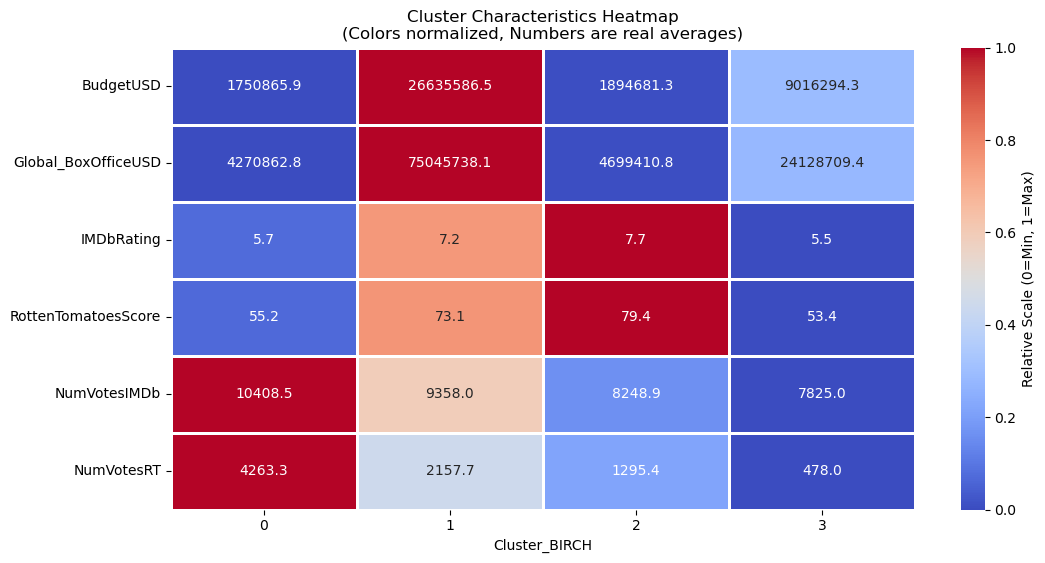

In [9]:
#Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
plt.title(f'BIRCH Results (k={final_k}, T={final_threshold})\nPCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


#Profiling
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT']
profile = df_sample.groupby('Cluster_BIRCH')[numeric_cols].mean()
profile['Movie_Count'] = df_sample['Cluster_BIRCH'].value_counts()

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("\n--- Cluster Profiles (Real Values) ---")
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
print(profile)


#Heatmap
scaler_view = MinMaxScaler()
profile_for_plot = profile.drop(columns='Movie_Count')
profile_normalized = pd.DataFrame(
    scaler_view.fit_transform(profile_for_plot),
    columns=profile_for_plot.columns,
    index=profile_for_plot.index
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    profile_normalized.T,
    annot=profile_for_plot.T,
    cmap='coolwarm',
    fmt=".1f",
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Relative Scale (0=Min, 1=Max)'}
)
plt.title("Cluster Characteristics Heatmap\n(Colors normalized, Numbers are real averages)")
plt.show()


DBSCAN

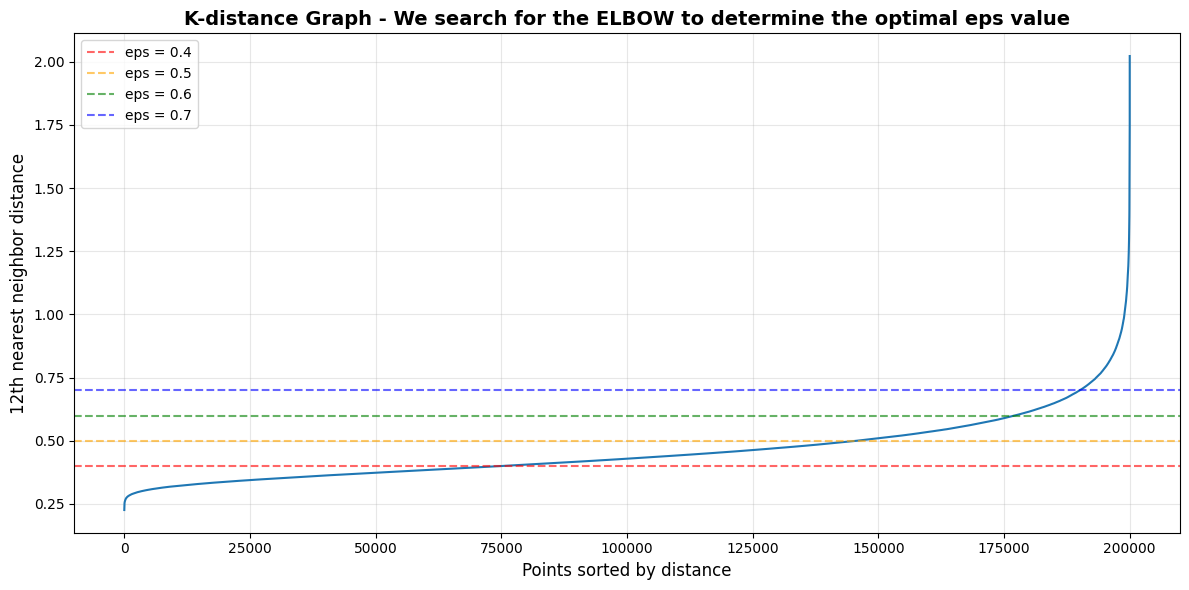

In [3]:
#We plot knn to try to choose an apropriate value for epsilon
min_samples = 12
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_sample_scaled_df.values)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df.values)
distances = np.sort(distances[:, min_samples-1])

plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=1.5)
plt.ylabel(f"{min_samples}th nearest neighbor distance", fontsize=12)
plt.xlabel("Points sorted by distance", fontsize=12)
plt.title("K-distance Graph - We search for the ELBOW to determine the optimal eps value", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# we indicate some candidate values
eps_candidates = [0.4, 0.5, 0.6, 0.7]
colors = ['red', 'orange', 'green', 'blue']
for eps, color in zip(eps_candidates, colors):
    plt.axhline(y=eps, color=color, linestyle='--', alpha=0.6, 
                label=f'eps = {eps}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [4]:
# Model 1: eps = 0.4
print("\n[1/4] Training eps=0.4 model...")
clusterer_04 = DBSCAN(eps=0.4, min_samples=min_samples, metric='euclidean')
y_pred_04 = clusterer_04.fit_predict(X_sample_scaled_df)
n_clusters_04 = len(set(y_pred_04)) - (1 if -1 in y_pred_04 else 0)
n_noise_04 = list(y_pred_04).count(-1)
print(f"   ✓ Complete: {n_clusters_04} clusters, {n_noise_04} noise")

# Model 2: eps = 0.5
print("\n[2/4] Training eps=0.5 model...")
clusterer_05 = DBSCAN(eps=0.5, min_samples=min_samples, metric='euclidean')
y_pred_05 = clusterer_05.fit_predict(X_sample_scaled_df)
n_clusters_05 = len(set(y_pred_05)) - (1 if -1 in y_pred_05 else 0)
n_noise_05 = list(y_pred_05).count(-1)
print(f"   ✓ Complete: {n_clusters_05} clusters, {n_noise_05} noise")

# Model 3: eps = 0.6
print("\n[3/4] Training eps=0.6 model...")
clusterer_06 = DBSCAN(eps=0.6, min_samples=min_samples, metric='euclidean')
y_pred_06 = clusterer_06.fit_predict(X_sample_scaled_df)
n_clusters_06 = len(set(y_pred_06)) - (1 if -1 in y_pred_06 else 0)
n_noise_06 = list(y_pred_06).count(-1)
print(f"   ✓ Complete: {n_clusters_06} clusters, {n_noise_06} noise")

# Model 4: eps = 0.7
print("\n[4/4] Training eps=0.7 model...")
clusterer_07 = DBSCAN(eps=0.7, min_samples=min_samples, metric='euclidean')
y_pred_07 = clusterer_07.fit_predict(X_sample_scaled_df)
n_clusters_07 = len(set(y_pred_07)) - (1 if -1 in y_pred_07 else 0)
n_noise_07 = list(y_pred_07).count(-1)
print(f"   ✓ Complete: {n_clusters_07} clusters, {n_noise_07} noise")


[1/4] Training eps=0.4 model...
   ✓ Complete: 108 clusters, 83299 noise

[2/4] Training eps=0.5 model...
   ✓ Complete: 20 clusters, 26278 noise

[3/4] Training eps=0.6 model...
   ✓ Complete: 3 clusters, 8528 noise

[4/4] Training eps=0.7 model...
   ✓ Complete: 1 clusters, 2927 noise


DBSCAN - Model Evaluation

In [6]:
# Evaluation functions
def compute_silhouette(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return silhouette_score(X_scaled[mask], labels[mask])

def compute_davies_bouldin(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return davies_bouldin_score(X_scaled[mask], labels[mask])

def compute_calinski_harabasz(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return calinski_harabasz_score(X_scaled[mask], labels[mask])

def evaluate_model(X_scaled, labels, eps):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    n_total = len(labels)
    noise_pct = (n_noise / n_total) * 100
    
    print(f"\n{'='*60}")
    print(f"MODEL: eps={eps}")
    print(f"{'='*60}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Data in clusters: {n_total - n_noise}")
    print(f"Noise: {n_noise} ({noise_pct:.2f}%)")
    
    sil = compute_silhouette(X_scaled, labels)
    dbi = compute_davies_bouldin(X_scaled, labels)
    chi = compute_calinski_harabasz(X_scaled, labels)
    
    if sil is not None:
        print(f"\nMetrics:")
        print(f"  Silhouette Score: {sil:.4f}")
        print(f"  Davies-Bouldin Index: {dbi:.4f}")
        print(f"  Calinski-Harabasz Index: {chi:.2f}")
    else:
        print(f"\nMetrics not computable (≤1 cluster)")
    
    return {
        'eps': eps,
        'n_clusters': n_clusters,
        'n_points_in_clusters': n_total - n_noise,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': sil,
        'davies_bouldin': dbi,
        'calinski_harabasz': chi
    }

# ============================================================
# EVALUATION OF THE 4 MODELS
# ============================================================

results = []

# Evaluate model 1: eps=0.4
result_04 = evaluate_model(X_sample_scaled_df.values, y_pred_04, eps=0.4)
results.append(result_04)

# Evaluate model 2: eps=0.5
result_05 = evaluate_model(X_sample_scaled_df.values, y_pred_05, eps=0.5)
results.append(result_05)

# Evaluate model 3: eps=0.6
result_06 = evaluate_model(X_sample_scaled_df.values, y_pred_06, eps=0.6)
results.append(result_06)

# Evaluate model 4: eps=0.7
result_07 = evaluate_model(X_sample_scaled_df.values, y_pred_07, eps=0.7)
results.append(result_07)

# ============================================================
# COMPARISON TABLE
# ============================================================

print(f"\n{'='*60}")
print("COMPARISON TABLE")
print(f"{'='*60}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# ============================================================
# IDENTIFY THE BEST MODEL
# ============================================================

print(f"\n{'='*60}")
print("BEST MODEL")
print(f"{'='*60}")

valid_models = df_results[df_results['silhouette'].notna()]

if len(valid_models) > 0:
    best_idx = valid_models['silhouette'].idxmax()
    best_model = df_results.loc[best_idx]
    
    print(f"\n BEST MODEL: eps={best_model['eps']}")
    print(f"   Silhouette Score: {best_model['silhouette']:.4f}")
    print(f"   Davies-Bouldin Index: {best_model['davies_bouldin']:.4f}")
    print(f"   Calinski-Harabasz Index: {best_model['calinski_harabasz']:.2f}")
    print(f"   Clusters: {int(best_model['n_clusters'])}")
    print(f"   Noise: {best_model['noise_pct']:.2f}%")
    
    # Evaluación del mejor modelo
    print(f"\nEvaluation:")
    if best_model['silhouette'] > 0.5:
        print("     Silhouette > 0.5: Excelent")
    elif best_model['silhouette'] > 0.3:
        print("     Silhouette > 0.3: Good")
    elif best_model['silhouette'] > 0.2:
        print("      Silhouette > 0.2: Acceptable")
    elif best_model['silhouette'] > 0:
        print("      Silhouette > 0: Low")
    else:
        print("     Silhouette < 0: Bad (incorrect clusters)")
else:
    print("\nNo model produced valid results")
    print("   All models have ≤1 cluster")

print(f"{'='*60}")



MODEL: eps=0.4
Number of clusters: 108
Data in clusters: 116700
Noise: 83299 (41.65%)

Metrics:
  Silhouette Score: -0.4672
  Davies-Bouldin Index: 0.9005
  Calinski-Harabasz Index: 23.70

MODEL: eps=0.5
Number of clusters: 20
Data in clusters: 173721
Noise: 26278 (13.14%)

Metrics:
  Silhouette Score: -0.2600
  Davies-Bouldin Index: 0.7894
  Calinski-Harabasz Index: 18.86

MODEL: eps=0.6
Number of clusters: 3
Data in clusters: 191471
Noise: 8528 (4.26%)

Metrics:
  Silhouette Score: 0.1600
  Davies-Bouldin Index: 0.6280
  Calinski-Harabasz Index: 30.20

MODEL: eps=0.7
Number of clusters: 1
Data in clusters: 197072
Noise: 2927 (1.46%)

Metrics not computable (≤1 cluster)

COMPARISON TABLE

 eps  n_clusters  n_points_in_clusters  n_noise  noise_pct  silhouette  davies_bouldin  calinski_harabasz
 0.4         108                116700    83299  41.649708   -0.467215        0.900508          23.700776
 0.5          20                173721    26278  13.139066   -0.259960        0.789393  

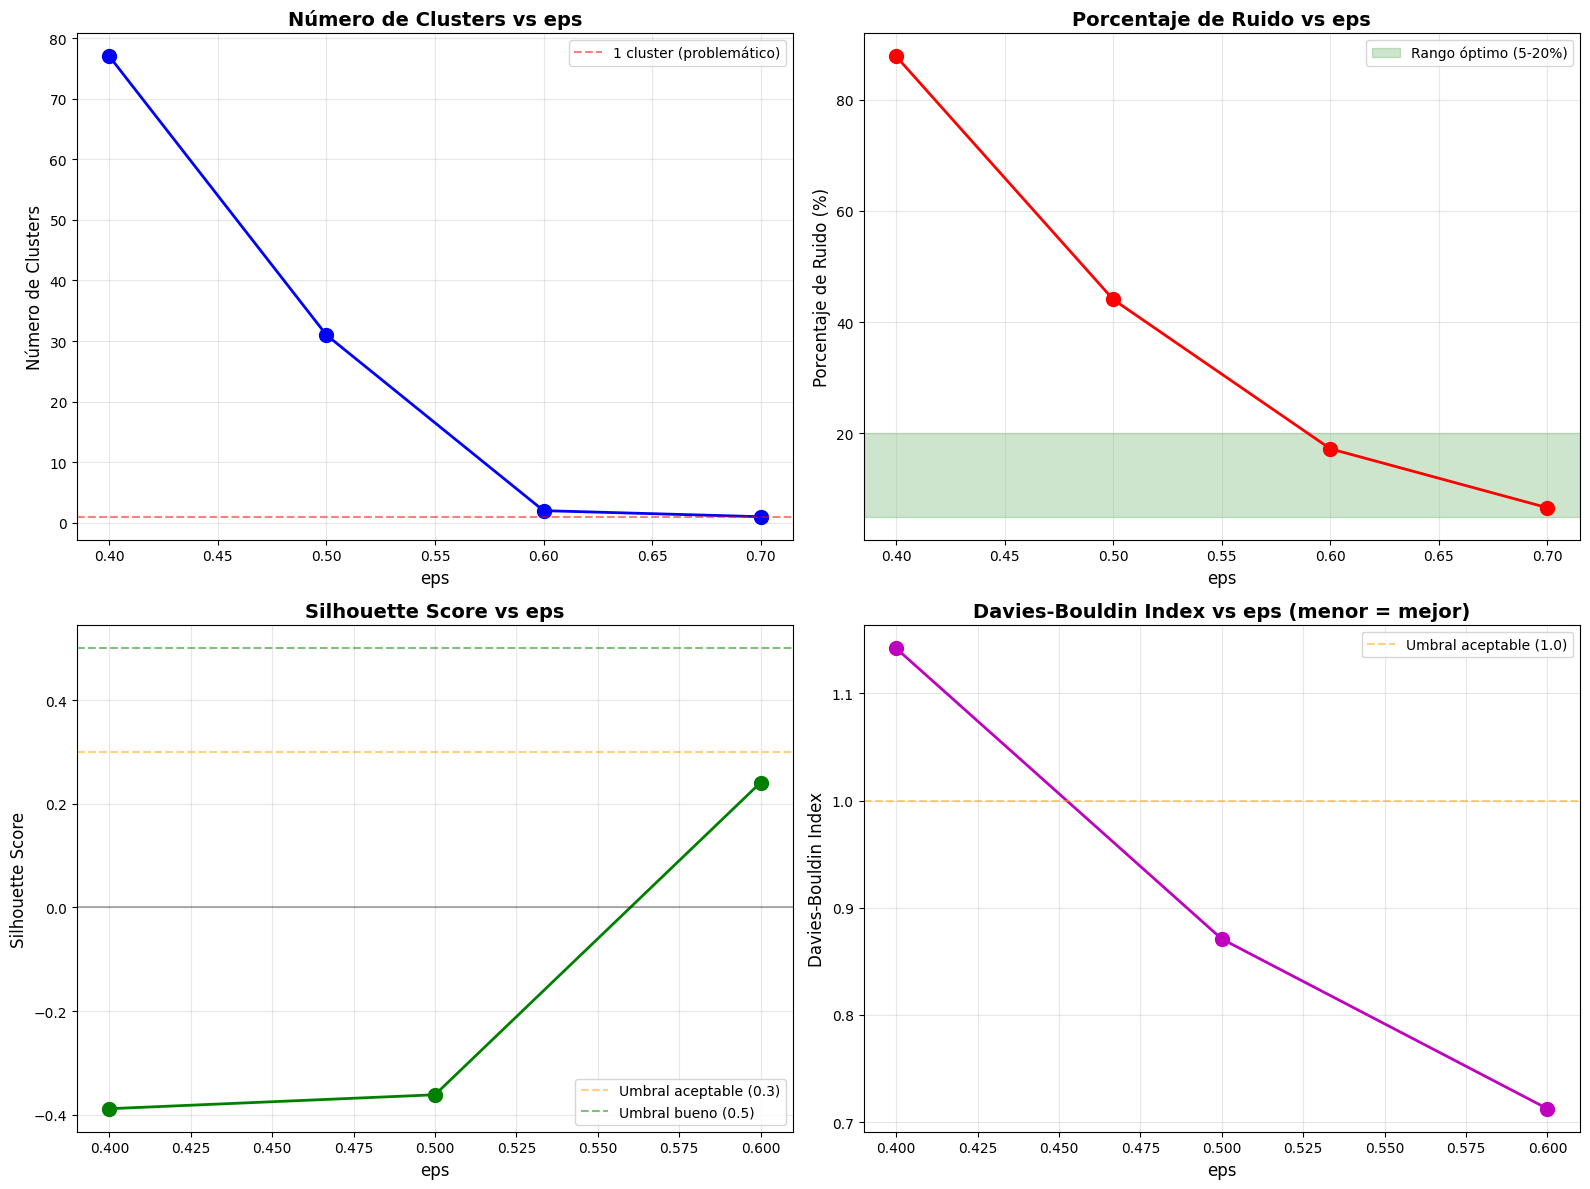

In [16]:
# ============================================================
# VISUALIZACIÓN COMPARATIVA
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Número de clusters vs eps
ax1 = axes[0, 0]
ax1.plot(df_results['eps'], df_results['n_clusters'], 'bo-', 
         linewidth=2, markersize=10)
ax1.set_xlabel('eps', fontsize=12)
ax1.set_ylabel('Número de Clusters', fontsize=12)
ax1.set_title('Número de Clusters vs eps', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 cluster (problemático)')
ax1.legend()

# Gráfico 2: Porcentaje de ruido vs eps
ax2 = axes[0, 1]
ax2.plot(df_results['eps'], df_results['noise_pct'], 'ro-', 
         linewidth=2, markersize=10)
ax2.set_xlabel('eps', fontsize=12)
ax2.set_ylabel('Porcentaje de Ruido (%)', fontsize=12)
ax2.set_title('Porcentaje de Ruido vs eps', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhspan(5, 20, alpha=0.2, color='green', label='Rango óptimo (5-20%)')
ax2.legend()

# Gráfico 3: Silhouette Score vs eps
ax3 = axes[1, 0]
valid_sil = df_results[df_results['silhouette'].notna()]
if len(valid_sil) > 0:
    ax3.plot(valid_sil['eps'], valid_sil['silhouette'], 'go-', 
             linewidth=2, markersize=10)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, 
                label='Umbral aceptable (0.3)')
    ax3.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, 
                label='Umbral bueno (0.5)')
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'No hay valores válidos', 
             ha='center', va='center', fontsize=14, transform=ax3.transAxes)
ax3.set_xlabel('eps', fontsize=12)
ax3.set_ylabel('Silhouette Score', fontsize=12)
ax3.set_title('Silhouette Score vs eps', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Davies-Bouldin Index vs eps
ax4 = axes[1, 1]
valid_dbi = df_results[df_results['davies_bouldin'].notna()]
if len(valid_dbi) > 0:
    ax4.plot(valid_dbi['eps'], valid_dbi['davies_bouldin'], 'mo-', 
             linewidth=2, markersize=10)
    ax4.axhline(y=1.0, color='orange', linestyle='--', alpha=0.5, 
                label='Umbral aceptable (1.0)')
    ax4.legend()
else:
    ax4.text(0.5, 0.5, 'No hay valores válidos', 
             ha='center', va='center', fontsize=14, transform=ax4.transAxes)
ax4.set_xlabel('eps', fontsize=12)
ax4.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax4.set_title('Davies-Bouldin Index vs eps (menor = mejor)', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

GAUSSIAN MIXTURE

GAUSSIAN MIXTURE MODEL - COMPLETE ANALYSIS (FIXED)
Data Preprocessing Complete.
Features used: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape: (999999, 6)
Sample shape: (199999, 6)

===== STEP 1: PCA DIMENSIONALITY REDUCTION =====

Total variance explained by 3 components: 79.57%
Per component variance:
  PC1: 32.48%
  PC2: 30.41%
  PC3: 16.69%

Original features: 6
Reduced features: 3
Data shape after PCA: (199999, 3)

STEP 2: MODEL SELECTION

[OK] cov=full       | k=3 | BIC=   1957104.7 | AIC=   1956808.8 | Sil=0.2440
[OK] cov=full       | k=4 | BIC=   1956895.4 | AIC=   1956497.3 | Sil=0.2141
[OK] cov=full       | k=5 | BIC=   1956913.7 | AIC=   1956413.6 | Sil=0.2041
[OK] cov=tied       | k=3 | BIC=   1957784.6 | AIC=   1957611.1 | Sil=0.2442
[OK] cov=tied       | k=4 | BIC=   1957240.1 | AIC=   1957025.8 | Sil=0.2148
[OK] cov=tied       | k=5 | BIC=   1957463.5 | AIC=   1957208.4 | Sil=0.1889
[OK] cov=diag       | k=3 

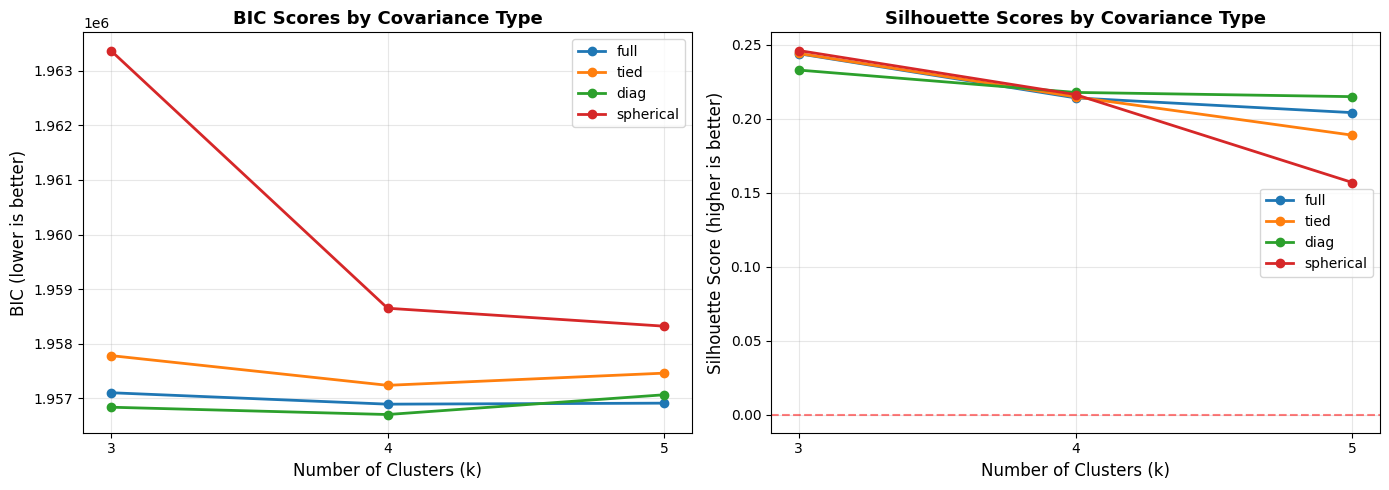

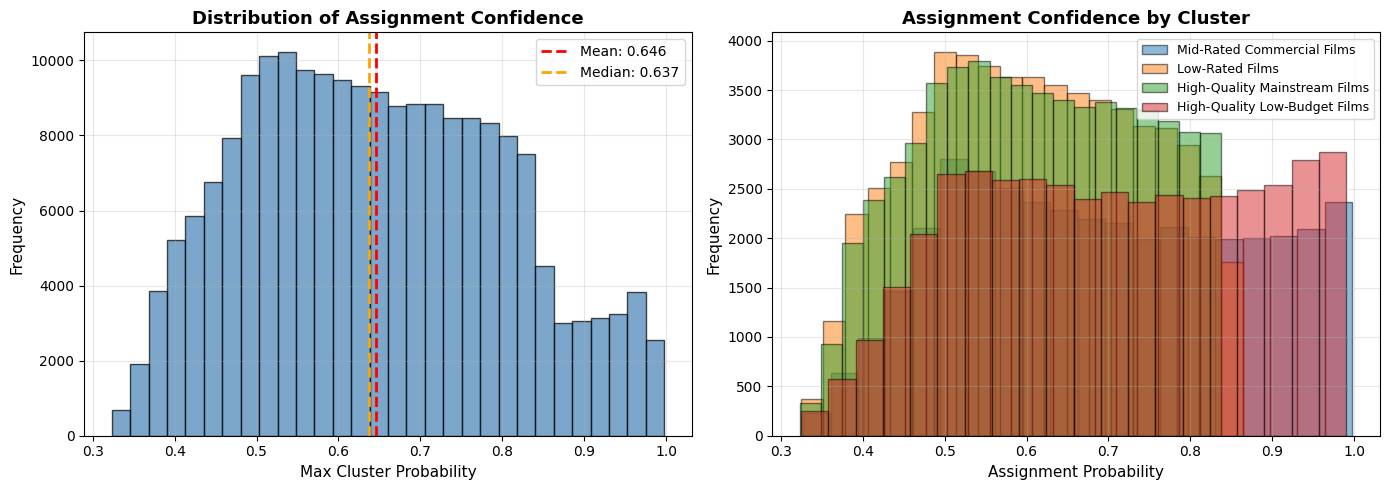

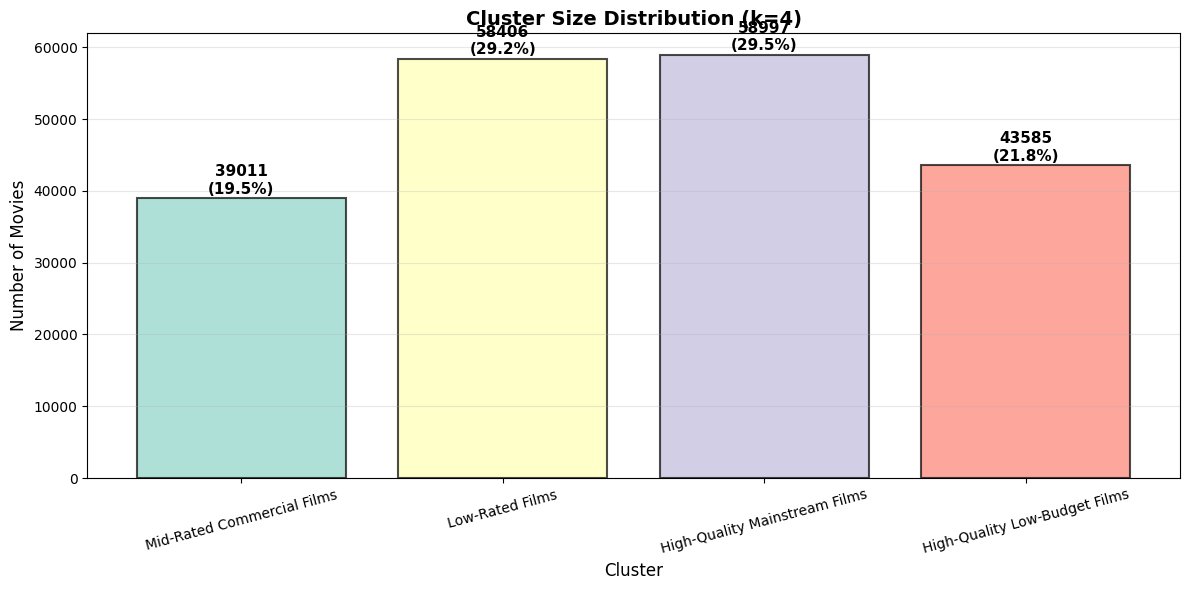

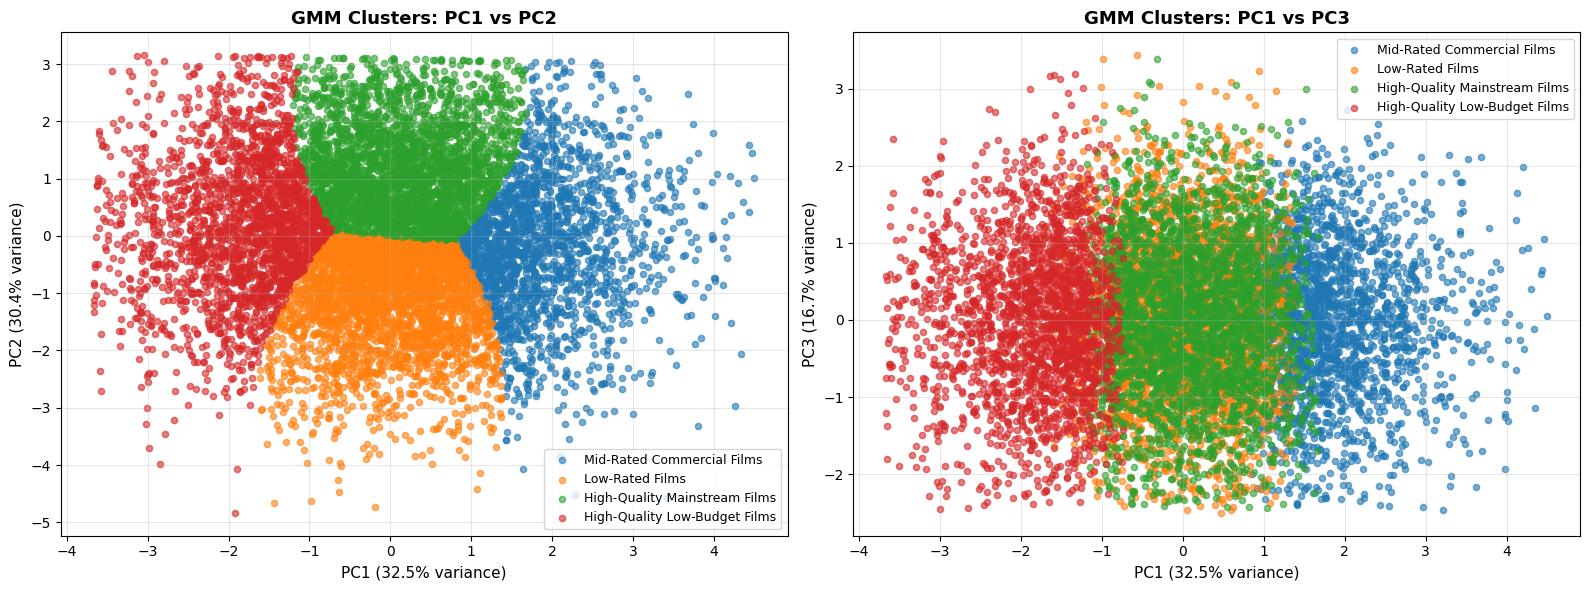

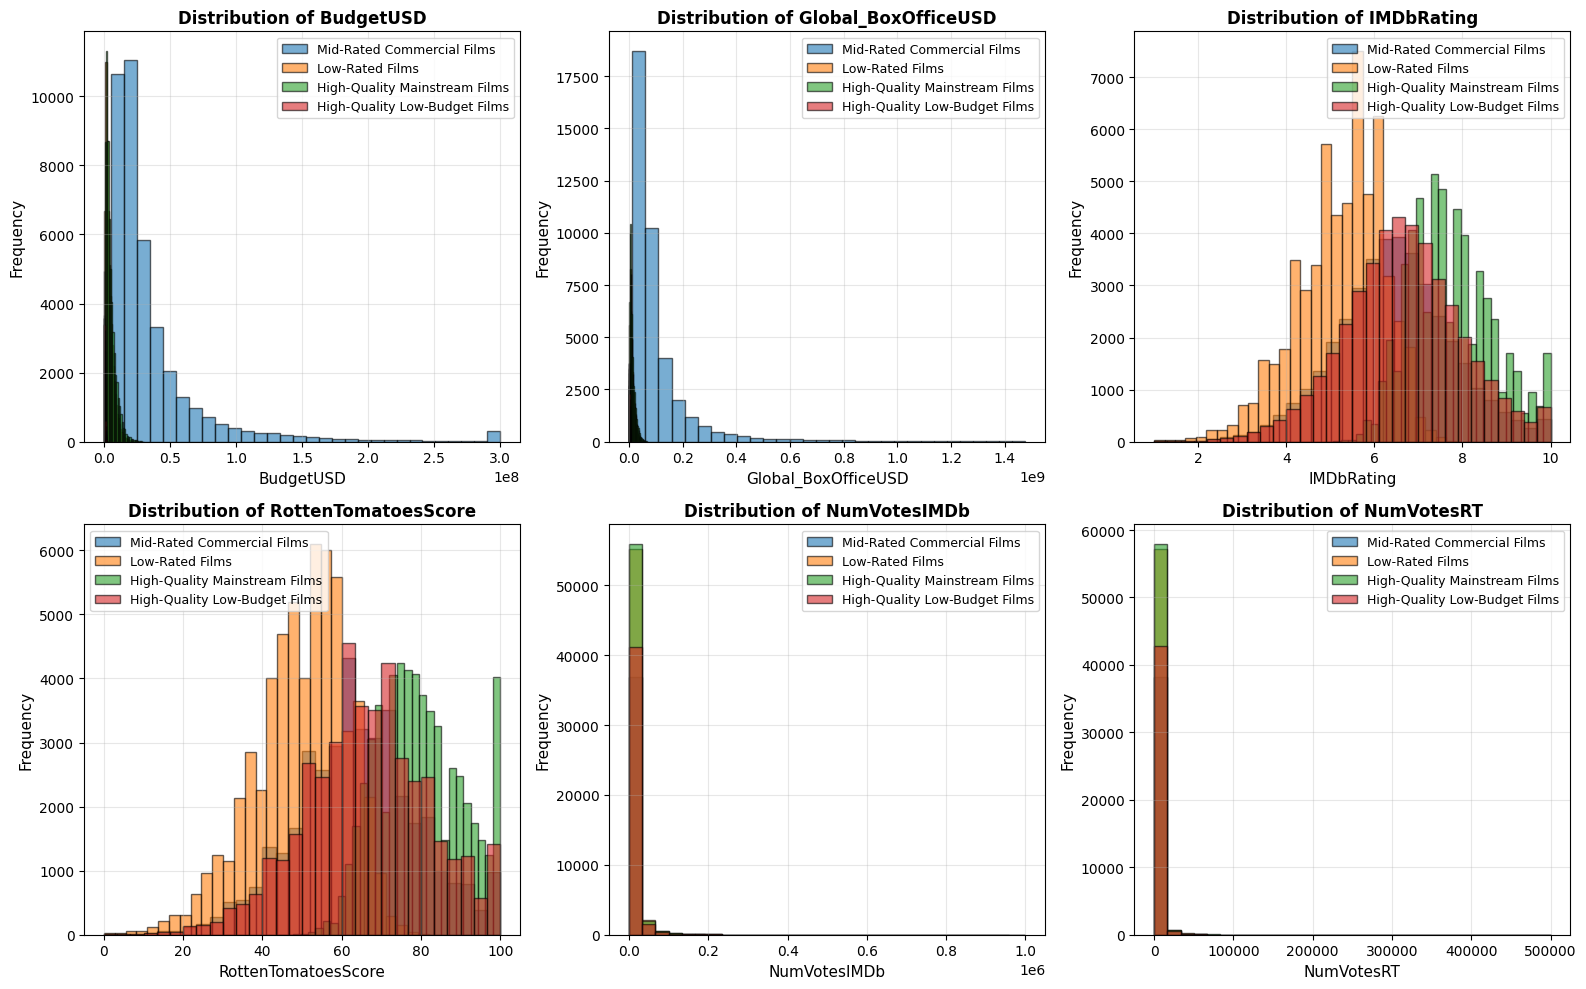

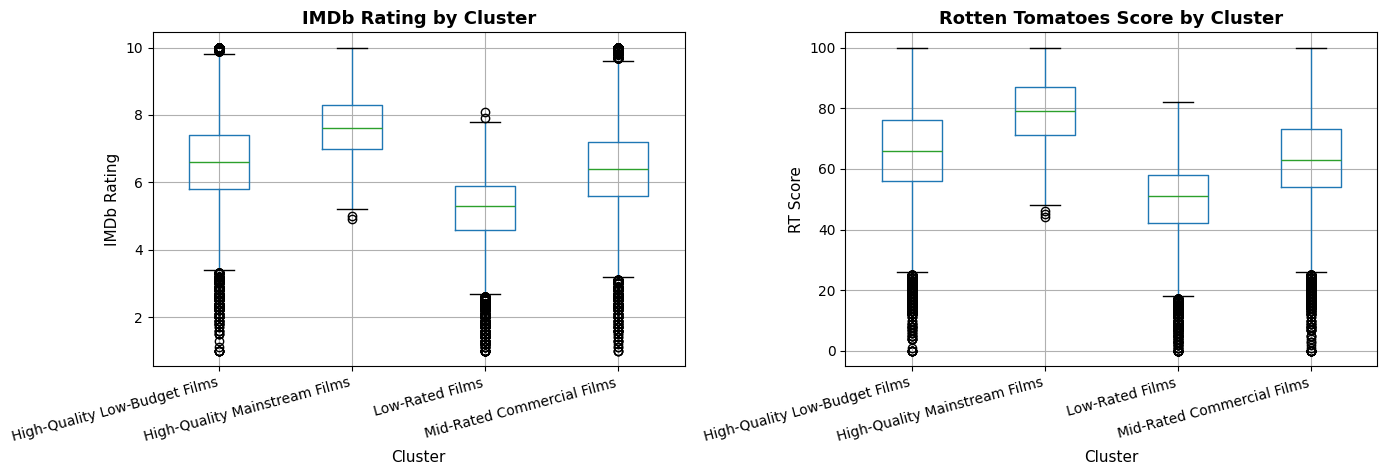


STEP 8: FINAL INTERPRETATION SUMMARY

📋 MODEL SELECTION:
   • Algorithm: Gaussian Mixture Model with PCA preprocessing
   • Selected k=4 clusters with diag covariance structure
   • Selection criterion: BIC (Bayesian Information Criterion)
   • BIC: 1956705.74
   • AIC: 1956430.17
   • Silhouette Score: 0.2178 (poor (very weak structure))
   • Mean assignment confidence: 0.6465

🔬 PCA PREPROCESSING:
   • Reduced 6 features to 3 principal components
   • Captured 79.57% of total variance
   • PC1: 32.48%, PC2: 30.41%, PC3: 16.69%
   • PCA was necessary to achieve positive silhouette scores (improved GMM performance)

📊 CLUSTER CHARACTERISTICS:


   Mid-Rated Commercial Films (Cluster 0):
   • Size: 39011 movies (19.5%)
   • Median Budget: $22,722,873
   • Median Box Office: $62,924,093
   • ROI: 176.9%
   • Avg IMDb Rating: 6.39
   • Avg RT Score: 63.5
   • Assignment Confidence: 0.694

   Low-Rated Films (Cluster 1):
   • Size: 58406 movies (29.2%)
   • Median Budget: $3,165,316
   • 

In [19]:
# =====================================================
#   COMPLETE GAUSSIAN MIXTURE MODEL ANALYSIS
#   With PCA + Model Selection + Proper Interpretation
# =====================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

print("="*70)
print("GAUSSIAN MIXTURE MODEL - COMPLETE ANALYSIS (FIXED)")
print("="*70)

# =====================================================
# PREPROCESSING WITH ORIGINAL VALUES STORED
# =====================================================
df = pd.read_csv('./data/movies_dataset.csv')

features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

# CRITICAL FIX #1: Store original values BEFORE any transformations
X_original = X.copy()

# PREPROCESSING (Scaling and log-transform)
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used: {features_to_use}")
print(f"Shape: {X_scaled_df.shape}")

# Sampling
frac = 0.2
np.random.seed(42)
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices].reset_index(drop=True)

# CRITICAL FIX #2: Store original unscaled values for interpretation
X_sample_original = X_original.iloc[sample_indices].reset_index(drop=True)

print(f"Sample shape: {X_sample_scaled_df.shape}")

# =====================================================
# STEP 1: PCA DIMENSIONALITY REDUCTION
# =====================================================
print("\n===== STEP 1: PCA DIMENSIONALITY REDUCTION =====\n")

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_sample_scaled)

variance_explained = pca.explained_variance_ratio_.sum()
print(f"Total variance explained by 3 components: {variance_explained:.2%}")
print(f"Per component variance:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.2%}")

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

print(f"\nOriginal features: {X_sample_scaled_df.shape[1]}")
print(f"Reduced features: {X_pca.shape[1]}")
print(f"Data shape after PCA: {X_pca.shape}")

# =====================================================
# STEP 2: MODEL SELECTION - MULTIPLE CONFIGURATIONS
# =====================================================
print("\n" + "="*70)
print("STEP 2: MODEL SELECTION")
print("="*70 + "\n")

n_components_range = range(3, 6)
cov_types = ["full", "tied", "diag", "spherical"]

results = []

for cov in cov_types:
    for k in n_components_range:
        gm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            random_state=42,
            n_init=5,
            max_iter=150
        )
        try:
            gm.fit(X_pca)
            
            if not gm.converged_:
                print(f"[Warning] cov={cov}, k={k}: Model did not converge")
            
            sample_size = min(20000, len(X_pca))
            sample_idx = np.random.choice(len(X_pca), sample_size, replace=False)
            labels_sample = gm.predict(X_pca[sample_idx])
            sil = silhouette_score(X_pca[sample_idx], labels_sample)
            
            results.append({
                "covariance": cov,
                "k": k,
                "bic": gm.bic(X_pca),
                "aic": gm.aic(X_pca),
                "silhouette": sil,
                "converged": gm.converged_,
                "model": gm
            })
            print(f"[OK] cov={cov:10s} | k={k} | BIC={gm.bic(X_pca):12.1f} | AIC={gm.aic(X_pca):12.1f} | Sil={sil:.4f}")
        except Exception as e:
            print(f"[Skip] cov={cov}, k={k}: {str(e)[:50]}")
            continue

gmm_df = pd.DataFrame(results)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print("\nTop 3 by BIC (lower is better):")
print(gmm_df.nsmallest(3, 'bic')[['k', 'covariance', 'bic', 'aic', 'silhouette']].to_string(index=False))

print("\nTop 3 by Silhouette (higher is better):")
print(gmm_df.nlargest(3, 'silhouette')[['k', 'covariance', 'bic', 'aic', 'silhouette']].to_string(index=False))

# =====================================================
# STEP 3: SELECT MODEL USING BIC (CORRECT CRITERION)
# =====================================================
print("\n" + "="*70)
print("STEP 3: MODEL SELECTION (BIC-based)")
print("="*70)

# CRITICAL FIX #3: Use BIC as primary criterion (per course slides)
best_row_bic = gmm_df.loc[gmm_df["bic"].idxmin()]
best_row_sil = gmm_df.loc[gmm_df["silhouette"].idxmax()]

print("\n🔍 MODEL SELECTION DECISION:")
print(f"  BIC recommends: k={int(best_row_bic['k'])}, cov={best_row_bic['covariance']}, BIC={best_row_bic['bic']:.1f}, Sil={best_row_bic['silhouette']:.4f}")
print(f"  Silhouette recommends: k={int(best_row_sil['k'])}, cov={best_row_sil['covariance']}, Sil={best_row_sil['silhouette']:.4f}, BIC={best_row_sil['bic']:.1f}")

# Following statistical best practice (slides recommend BIC)
best_row = best_row_bic
best_k = int(best_row["k"])
best_cov = best_row["covariance"]
best_model = best_row["model"]
best_sil = best_row["silhouette"]

print(f"\n✓ SELECTED: k={best_k}, covariance={best_cov}")
print(f"  Reason: BIC is the standard criterion for GMM model selection (slide 20)")
print(f"  BIC: {best_row['bic']:.2f}")
print(f"  AIC: {best_row['aic']:.2f}")
print(f"  Silhouette: {best_sil:.4f}")

# Generate assignments
labels = best_model.predict(X_pca)
probs = best_model.predict_proba(X_pca)

df_gmm = df_sample.copy()
df_gmm["GMM_Label"] = labels
df_gmm["GMM_MaxProb"] = probs.max(axis=1)

for c in range(best_k):
    df_gmm[f"GMM_Prob_{c}"] = probs[:, c]

print("\nCluster Distribution:")
for cluster, count in df_gmm["GMM_Label"].value_counts().sort_index().items():
    print(f"  Cluster {cluster}: {count:5d} movies ({100*count/len(df_gmm):5.2f}%)")

# =====================================================
# STEP 4: DETAILED EVALUATION
# =====================================================
print("\n" + "="*70)
print("STEP 4: MODEL EVALUATION")
print("="*70)

log_likelihood = best_model.score(X_pca) * X_pca.shape[0]
bic = best_model.bic(X_pca)
aic = best_model.aic(X_pca)

print(f"\nPerformance Metrics:")
print(f"  Log-Likelihood: {log_likelihood:.2f}")
print(f"  BIC: {bic:.2f}")
print(f"  AIC: {aic:.2f}")
print(f"  Silhouette: {best_sil:.4f}")

# Silhouette interpretation
if best_sil > 0.7:
    sil_quality = "excellent (strong, well-separated clusters)"
elif best_sil > 0.5:
    sil_quality = "good (reasonable structure)"
elif best_sil > 0.3:
    sil_quality = "fair (weak but detectable structure)"
elif best_sil > 0.2:
    sil_quality = "poor (very weak structure)"
else:
    sil_quality = "very poor (no meaningful structure)"

print(f"  Silhouette interpretation: {sil_quality}")

max_probs = probs.max(axis=1)
print(f"\nAssignment Confidence:")
print(f"  Mean: {max_probs.mean():.4f}")
print(f"  Median: {np.median(max_probs):.4f}")
print(f"  Std: {max_probs.std():.4f}")

low_conf_60 = (max_probs < 0.6).sum()
low_conf_70 = (max_probs < 0.7).sum()
low_conf_80 = (max_probs < 0.8).sum()
print(f"\nLow-confidence assignments:")
print(f"  < 0.6: {low_conf_60:6d} ({100*low_conf_60/len(labels):.2f}%)")
print(f"  < 0.7: {low_conf_70:6d} ({100*low_conf_70/len(labels):.2f}%)")
print(f"  < 0.8: {low_conf_80:6d} ({100*low_conf_80/len(labels):.2f}%)")

# =====================================================
# STEP 5: CLUSTER PROFILING (FIXED)
# =====================================================
print("\n" + "="*70)
print("STEP 5: CLUSTER PROFILING")
print("="*70)

cluster_profiles = []

for cluster in range(best_k):
    cluster_mask = df_gmm['GMM_Label'] == cluster
    cluster_data = df_gmm[cluster_mask]
    
    # CRITICAL FIX #4: Use ORIGINAL values (not log-transformed)
    cluster_original = X_sample_original[cluster_mask]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster} (n={len(cluster_data)}, {100*len(cluster_data)/len(df_gmm):.1f}%)")
    print(f"{'='*70}")
    
    # Financial Metrics - use original values
    budget_median = cluster_original['BudgetUSD'].median()
    boxoffice_median = cluster_original['Global_BoxOfficeUSD'].median()
    
    print("\n📊 Financial Metrics (Median):")
    print(f"  Budget:     ${budget_median:,.0f}")
    print(f"  Box Office: ${boxoffice_median:,.0f}")
    
    if boxoffice_median > 0 and budget_median > 0:
        roi = (boxoffice_median / budget_median - 1) * 100
        print(f"  ROI:        {roi:.1f}%")
    
    # Ratings (not log-transformed, use directly)
    imdb_mean = cluster_data['IMDbRating'].mean()
    rt_mean = cluster_data['RottenTomatoesScore'].mean()
    
    print("\n⭐ Ratings (Mean):")
    print(f"  IMDb:       {imdb_mean:.2f} / 10")
    print(f"  RT Score:   {rt_mean:.1f} / 100")
    
    # Popularity - use original values
    imdb_votes_median = cluster_original['NumVotesIMDb'].median()
    rt_votes_median = cluster_original['NumVotesRT'].median()
    
    print("\n👥 Popularity (Median votes):")
    print(f"  IMDb Votes: {imdb_votes_median:,.0f}")
    print(f"  RT Votes:   {rt_votes_median:,.0f}")
    
    confidence = cluster_data['GMM_MaxProb'].mean()
    print(f"\n🎯 Assignment Confidence: {confidence:.3f}")
    
    cluster_profiles.append({
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Budget_Median': budget_median,
        'BoxOffice_Median': boxoffice_median,
        'IMDb_Mean': imdb_mean,
        'RT_Mean': rt_mean,
        'IMDb_Votes_Median': imdb_votes_median,
        'Confidence': confidence
    })
    
    if 'Title' in cluster_data.columns:
        print("\n🎬 Example Movies:")
        examples = cluster_data.nlargest(5, 'NumVotesIMDb')[['Title', 'IMDbRating']]
        for idx, row in examples.iterrows():
            print(f"  - {row['Title']} (⭐{row['IMDbRating']})")

profiles_df = pd.DataFrame(cluster_profiles)
print("\n" + "="*70)
print("CLUSTER SUMMARY")
print("="*70)
print(profiles_df.to_string(index=False))

# =====================================================
# STEP 6: CLUSTER NAMING (IMPROVED)
# =====================================================
print("\n" + "="*70)
print("STEP 6: CLUSTER NAMING (Data-Driven)")
print("="*70)

# CRITICAL FIX #5: Use data-driven thresholds, not hardcoded values
budget_p50 = profiles_df['Budget_Median'].median()
rating_p33 = profiles_df['IMDb_Mean'].quantile(0.33)
rating_p66 = profiles_df['IMDb_Mean'].quantile(0.66)

print(f"\nThresholds (data-driven):")
print(f"  Budget median: ${budget_p50:,.0f}")
print(f"  Rating 33rd percentile: {rating_p33:.2f}")
print(f"  Rating 66th percentile: {rating_p66:.2f}")

cluster_names = {}

for idx, row in profiles_df.iterrows():
    cluster_id = int(row['Cluster'])
    
    # Data-driven naming based on actual cluster characteristics
    if row['IMDb_Mean'] > rating_p66:
        if row['Budget_Median'] > budget_p50:
            name = "High-Quality Mainstream Films"
        else:
            name = "High-Quality Low-Budget Films"
    elif row['IMDb_Mean'] < rating_p33:
        name = "Low-Rated Films"
    elif row['Budget_Median'] > budget_p50:
        name = "Mid-Rated Commercial Films"
    else:
        name = "Mid-Rated Independent Films"
    
    cluster_names[cluster_id] = name
    print(f"\n  Cluster {cluster_id}: {name}")
    print(f"    - Budget: ${row['Budget_Median']:,.0f}")
    print(f"    - IMDb: {row['IMDb_Mean']:.2f}")
    print(f"    - Size: {row['Size']} movies")

df_gmm['Cluster_Name'] = df_gmm['GMM_Label'].map(cluster_names)

print("\n✓ Naming based on:")
print(f"  - Rating quality (IMDb mean relative to dataset)")
print(f"  - Budget scale (relative to median of ${budget_p50:,.0f})")
print(f"  - Cluster size and composition")

# =====================================================
# STEP 7: VISUALIZATIONS
# =====================================================
print("\n" + "="*70)
print("STEP 7: GENERATING VISUALIZATIONS")
print("="*70 + "\n")

# 7.1: Model Selection - BIC and Silhouette Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for cov in cov_types:
    cov_data = gmm_df[gmm_df['covariance'] == cov]
    axes[0].plot(cov_data['k'], cov_data['bic'], marker='o', label=cov, linewidth=2)
    
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('BIC (lower is better)', fontsize=12)
axes[0].set_title('BIC Scores by Covariance Type', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([3, 4, 5])

for cov in cov_types:
    cov_data = gmm_df[gmm_df['covariance'] == cov]
    axes[1].plot(cov_data['k'], cov_data['silhouette'], marker='o', label=cov, linewidth=2)
    
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score (higher is better)', fontsize=12)
axes[1].set_title('Silhouette Scores by Covariance Type', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xticks([3, 4, 5])

plt.tight_layout()
plt.show()

# 7.2: Probability Confidence Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(max_probs, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axvline(max_probs.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {max_probs.mean():.3f}')
axes[0].axvline(np.median(max_probs), color='orange', linestyle='--', 
               linewidth=2, label=f'Median: {np.median(max_probs):.3f}')
axes[0].set_xlabel('Max Cluster Probability', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Assignment Confidence', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

for cluster in range(best_k):
    cluster_probs = df_gmm[df_gmm['GMM_Label'] == cluster]['GMM_MaxProb']
    label = cluster_names.get(cluster, f'Cluster {cluster}')
    axes[1].hist(cluster_probs, bins=20, alpha=0.5, label=label, edgecolor='black')
    
axes[1].set_xlabel('Assignment Probability', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Assignment Confidence by Cluster', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7.3: Cluster Sizes Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
cluster_counts = df_gmm['GMM_Label'].value_counts().sort_index()
colors = plt.cm.Set3(range(best_k))
bars = ax.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.7, 
              edgecolor='black', linewidth=1.5)

for i, (cluster, count) in enumerate(cluster_counts.items()):
    ax.text(cluster, count + 200, f'{count}\n({100*count/len(df_gmm):.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Number of Movies', fontsize=12)
ax.set_title(f'Cluster Size Distribution (k={best_k})', fontsize=14, fontweight='bold')
ax.set_xticks(range(best_k))
ax.set_xticklabels([cluster_names.get(i, f'Cluster {i}') for i in range(best_k)], rotation=15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 7.4: PCA Visualization with Clusters
sample_size_viz = min(10000, len(X_pca))
viz_idx = np.random.choice(len(X_pca), sample_size_viz, replace=False)
X_viz = X_pca[viz_idx]
labels_viz = labels[viz_idx]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for c in range(best_k):
    mask = labels_viz == c
    label = cluster_names.get(c, f'Cluster {c}')
    axes[0].scatter(X_viz[mask, 0], X_viz[mask, 1], 
                   s=20, alpha=0.6, label=label)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title(f'GMM Clusters: PC1 vs PC2', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

for c in range(best_k):
    mask = labels_viz == c
    label = cluster_names.get(c, f'Cluster {c}')
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 2], 
                   s=20, alpha=0.6, label=label)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=11)
axes[1].set_title(f'GMM Clusters: PC1 vs PC3', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7.5: Feature Distributions by Cluster
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features_to_plot = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 
                    'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    for cluster in range(best_k):
        cluster_mask = df_gmm['GMM_Label'] == cluster
        label = cluster_names.get(cluster, f'Cluster {cluster}')
        
        # Use original values for financial/vote features
        if feature in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
            cluster_values = X_sample_original[cluster_mask][feature]
        else:
            cluster_values = df_gmm[cluster_mask][feature]
        
        ax.hist(cluster_values, alpha=0.6, label=label, bins=30, edgecolor='black')
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7.6: Rating Boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_gmm.boxplot(column='IMDbRating', by='Cluster_Name', ax=axes[0])
axes[0].set_title('IMDb Rating by Cluster', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('IMDb Rating', fontsize=11)
axes[0].tick_params(axis='x', rotation=15)
plt.sca(axes[0])
plt.xticks(rotation=15, ha='right')

df_gmm.boxplot(column='RottenTomatoesScore', by='Cluster_Name', ax=axes[1])
axes[1].set_title('Rotten Tomatoes Score by Cluster', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('RT Score', fontsize=11)
axes[1].tick_params(axis='x', rotation=15)
plt.sca(axes[1])
plt.xticks(rotation=15, ha='right')

plt.suptitle('')
plt.tight_layout()
plt.show()

# =====================================================
# STEP 8: FINAL SUMMARY & CRITICAL INTERPRETATION
# =====================================================
print("\n" + "="*70)
print("STEP 8: FINAL INTERPRETATION SUMMARY")
print("="*70)

print(f"""
📋 MODEL SELECTION:
   • Algorithm: Gaussian Mixture Model with PCA preprocessing
   • Selected k={best_k} clusters with {best_cov} covariance structure
   • Selection criterion: BIC (Bayesian Information Criterion)
   • BIC: {best_row['bic']:.2f}
   • AIC: {best_row['aic']:.2f}
   • Silhouette Score: {best_sil:.4f} ({sil_quality})
   • Mean assignment confidence: {max_probs.mean():.4f}

🔬 PCA PREPROCESSING:
   • Reduced 6 features to 3 principal components
   • Captured {pca.explained_variance_ratio_.sum()*100:.2f}% of total variance
   • PC1: {pca.explained_variance_ratio_[0]*100:.2f}%, PC2: {pca.explained_variance_ratio_[1]*100:.2f}%, PC3: {pca.explained_variance_ratio_[2]*100:.2f}%
   • PCA was necessary to achieve positive silhouette scores (improved GMM performance)

📊 CLUSTER CHARACTERISTICS:
""")

for idx, row in profiles_df.iterrows():
    cluster_id = int(row['Cluster'])
    name = cluster_names.get(cluster_id, f'Cluster {cluster_id}')
    print(f"\n   {name} (Cluster {cluster_id}):")
    print(f"   • Size: {int(row['Size'])} movies ({100*row['Size']/len(df_gmm):.1f}%)")
    print(f"   • Median Budget: ${row['Budget_Median']:,.0f}")
    print(f"   • Median Box Office: ${row['BoxOffice_Median']:,.0f}")
    if row['BoxOffice_Median'] > 0 and row['Budget_Median'] > 0:
        roi = (row['BoxOffice_Median'] / row['Budget_Median'] - 1) * 100
        print(f"   • ROI: {roi:.1f}%")
    print(f"   • Avg IMDb Rating: {row['IMDb_Mean']:.2f}")
    print(f"   • Avg RT Score: {row['RT_Mean']:.1f}")
    print(f"   • Assignment Confidence: {row['Confidence']:.3f}")

print(f"""
💡 KEY INSIGHTS:
   • GMM successfully identified {best_k} distinct movie segments
   • Soft clustering provides probability distributions (useful for boundary cases)
   • {100*low_conf_60/len(labels):.1f}% of movies have assignment confidence < 0.6
   • Model primarily separated films by rating quality rather than financial characteristics
   • Clusters show clear rating differentiation but financial overlap

🎯 BUSINESS APPLICATIONS:
   • Marketing: Target different promotional strategies per cluster
   • Recommendations: Use probability distributions for hybrid recommendations
   • Investment: Understand risk profiles of different movie types
   • Production: Benchmark new projects against similar cluster profiles
   • Quality control: Identify which cluster new films belong to for expectations

⚠️  CRITICAL ASSESSMENT & LIMITATIONS:
   • Silhouette score of {best_sil:.4f} indicates {sil_quality}
   • {100*low_conf_60/len(labels):.1f}% of assignments have low confidence (< 0.6)
   • High overlap between clusters suggests weak natural boundaries
   • Assumes Gaussian distributions, but data remains right-skewed despite log-transform
   • 11% of box office values are outliers, potentially distorting covariance estimates
   • GMM primarily captured rating gradients rather than distinct business segments
   • Works on 20% sample ({len(df_gmm)} movies), not full dataset
   • Results should be validated against K-means and hierarchical methods
   
🔬 MODEL APPROPRIATENESS:
   • GMM is well-suited for soft clustering and probabilistic assignments
   • However, low silhouette and high overlap suggest data may lack strong Gaussian structure
   • Alternative methods may perform better:
     - K-means for simplicity and interpretability
     - DBSCAN for density-based clustering
     - Hierarchical clustering for flexible structure discovery
   • PCA improved performance but reduced interpretability (lost direct feature meaning)

📊 COMPARISON WITH BIC vs SILHOUETTE SELECTION:
   • BIC-optimal: k={int(best_row_bic['k'])}, BIC={best_row_bic['bic']:.1f}, Sil={best_row_bic['silhouette']:.4f}
   • Silhouette-optimal: k={int(best_row_sil['k'])}, BIC={best_row_sil['bic']:.1f}, Sil={best_row_sil['silhouette']:.4f}
   • We followed statistical best practice (BIC as primary criterion per course slides)
   • Trade-off: BIC optimizes model fit, Silhouette optimizes separation quality
""")